# Lesson 5 Exercise: Improve Q&A Accuracy with Attention Layers

**Estimated Time:** 15 minutes

## Overview

In Lesson 4, you built a Q&A system but discovered the **context vector bottleneck** - long contexts hurt performance (55% accuracy). Today, you'll fix this by implementing attention mechanisms!

## What You'll Do

1. **Part A:** Implement `AttentionLayer` class (compute attention weights)
2. **Part B:** Implement `DecoderWithAttention` (integrate attention into decoder)
3. **Part C:** Train your model and compare to baseline
4. **Part D:** Visualize attention heatmaps

## Expected Results

If implemented correctly:
- Long context accuracy: 55% → 85% (+30 points!)
- Attention heatmaps show model "looking" at relevant words
- Bottleneck eliminated ✓

---

## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

# Import data utilities (from Lesson 4)
from data import (
    SyntheticQAGenerator,
    build_vocabulary,
    encode_text,
    decode_text,
    PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, SEP_TOKEN
)

# Import model classes (you'll implement the attention parts!)
from models import (
    Encoder,  # From Lesson 4 - provided
    AttentionLayer,  # NEW - YOU implement!
    DecoderWithAttention,  # NEW - YOU implement!
    Seq2SeqWithAttention,  # NEW - YOU implement!
    count_parameters
)

# Import visualization
from attention_viz import plot_attention, highlight_max_attention

# Set seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("\n✓ Imports successful!")
print("\n⚠️  Remember: You need to implement the attention classes in models.py!")

Using device: cpu

✓ Imports successful!

⚠️  Remember: You need to implement the attention classes in models.py!


---

# Part A: Implement Attention Mechanism

Your first task is to implement the `AttentionLayer` class in `models.py`.

## What Attention Does

```
Without Attention:
  Encoder: [h1, h2, h3, ..., hN] → Only use hN (bottleneck!)

With Attention:
  Encoder: [h1, h2, h3, ..., hN] → Use ALL states!
  
  At each decoder step:
    1. Compute scores for each encoder state
    2. Apply softmax → attention weights
    3. Weighted sum → context vector
```

## Your Task

Open `models.py` and complete the `AttentionLayer` class:

1. Initialize layers in `__init__`
2. Implement the `forward` method following the TODOs

## Test Your Implementation

In [2]:
print("="*80)
print("TESTING YOUR AttentionLayer IMPLEMENTATION")
print("="*80)

try:
    # Test AttentionLayer
    attn = AttentionLayer(hidden_dim=256)
    
    # Create test inputs
    batch_size = 4
    src_len = 20
    hidden_dim = 256
    
    test_hidden = torch.randn(batch_size, hidden_dim)
    test_encoder = torch.randn(batch_size, src_len, hidden_dim * 2)
    
    # Forward pass
    context, weights = attn(test_hidden, test_encoder)
    
    # Check shapes
    print("\nShape Checks:")
    print(f"  Context shape: {context.shape} (expected: [{batch_size}, {hidden_dim*2}])")
    print(f"  Weights shape: {weights.shape} (expected: [{batch_size}, {src_len}])")
    
    assert context.shape == (batch_size, hidden_dim * 2), \
        f"❌ Context shape is {context.shape}, expected ({batch_size}, {hidden_dim*2})"
    assert weights.shape == (batch_size, src_len), \
        f"❌ Weights shape is {weights.shape}, expected ({batch_size}, {src_len})"
    
    print("  ✓ Shapes correct!")
    
    # Check that weights sum to 1
    weight_sums = weights.sum(dim=1)
    print(f"\nAttention Weight Sums: {weight_sums}")
    assert torch.allclose(weight_sums, torch.ones(batch_size), atol=1e-6), \
        f"❌ Attention weights don't sum to 1.0! Got: {weight_sums}"
    
    print("  ✓ Weights sum to 1.0!")
    
    # Check that weights are non-negative
    assert (weights >= 0).all(), "❌ Attention weights contain negative values!"
    print("  ✓ All weights non-negative!")
    
    print("\n" + "="*80)
    print("🎉 SUCCESS! Your AttentionLayer is working correctly!")
    print("="*80)
    
except NotImplementedError as e:
    print("\n❌ AttentionLayer not implemented yet!")
    print("   Go to models.py and complete the TODOs in the AttentionLayer class.")
except Exception as e:
    print(f"\n❌ Error in AttentionLayer: {e}")
    print("   Check your implementation against the hints in models.py")

TESTING YOUR AttentionLayer IMPLEMENTATION

Shape Checks:
  Context shape: torch.Size([4, 512]) (expected: [4, 512])
  Weights shape: torch.Size([4, 20]) (expected: [4, 20])
  ✓ Shapes correct!

Attention Weight Sums: tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)
  ✓ Weights sum to 1.0!
  ✓ All weights non-negative!

🎉 SUCCESS! Your AttentionLayer is working correctly!


---

# Part B: Integrate Attention into Decoder

Now implement `DecoderWithAttention` and `Seq2SeqWithAttention` in `models.py`.

## Key Changes from Lesson 4

**Lesson 4 Decoder:**
```python
def forward(x, hidden, cell):
    embedded = self.embedding(x)
    output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
    return output, hidden, cell
```

**Lesson 5 Decoder (with Attention):**
```python
def forward(x, hidden, cell, encoder_outputs):  # ← Extra parameter!
    embedded = self.embedding(x)
    
    # NEW: Compute attention
    context, attn_weights = self.attention(hidden, encoder_outputs)
    
    # NEW: Concatenate with embedding
    lstm_input = torch.cat([embedded, context], dim=2)
    
    output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
    return output, hidden, cell, attn_weights  # ← Return attention!
```

## Test Your Implementation

In [3]:
print("="*80)
print("TESTING YOUR DecoderWithAttention IMPLEMENTATION")
print("="*80)

try:
    # Test DecoderWithAttention
    vocab_size = 100
    embed_dim = 128
    hidden_dim = 256
    
    decoder = DecoderWithAttention(vocab_size, embed_dim, hidden_dim)
    
    # Create test inputs
    batch_size = 4
    src_len = 20
    
    test_input = torch.randint(0, vocab_size, (batch_size, 1))
    test_hidden = torch.randn(1, batch_size, hidden_dim)
    test_cell = torch.randn(1, batch_size, hidden_dim)
    test_encoder_outputs = torch.randn(batch_size, src_len, hidden_dim * 2)
    
    # Forward pass
    pred, h, c, attn = decoder(test_input, test_hidden, test_cell, test_encoder_outputs)
    
    # Check shapes
    print("\nShape Checks:")
    print(f"  Prediction shape: {pred.shape} (expected: [{batch_size}, 1, {vocab_size}])")
    print(f"  Attention shape:  {attn.shape} (expected: [{batch_size}, {src_len}])")
    
    assert pred.shape == (batch_size, 1, vocab_size), \
        f"❌ Prediction shape is {pred.shape}, expected ({batch_size}, 1, {vocab_size})"
    assert attn.shape == (batch_size, src_len), \
        f"❌ Attention shape is {attn.shape}, expected ({batch_size}, {src_len})"
    
    print("  ✓ Shapes correct!")
    
    print("\n" + "="*80)
    print("🎉 SUCCESS! Your DecoderWithAttention is working correctly!")
    print("="*80)
    
except NotImplementedError:
    print("\n❌ DecoderWithAttention not implemented yet!")
    print("   Go to models.py and complete the TODOs.")
except Exception as e:
    print(f"\n❌ Error in DecoderWithAttention: {e}")
    print("   Check your implementation against the hints.")

TESTING YOUR DecoderWithAttention IMPLEMENTATION

Shape Checks:
  Prediction shape: torch.Size([4, 1, 100]) (expected: [4, 1, 100])
  Attention shape:  torch.Size([4, 20]) (expected: [4, 20])
  ✓ Shapes correct!

🎉 SUCCESS! Your DecoderWithAttention is working correctly!


---

# Part C: Train and Compare

Now let's train your attention model and compare it to the Lesson 4 baseline!

## Load Data (Same as Lesson 4)

In [4]:
print("Loading data...")

# Generate same dataset as Lesson 4
generator = SyntheticQAGenerator(seed=42)
qa_data, context_lengths = generator.generate_dataset(
    n_short=400,
    n_medium=400,
    n_long=400,
    shuffle=True
)

# Build vocabulary
vocab, idx2word = build_vocabulary(qa_data)
vocab_size = len(vocab)

print(f"✓ Generated {len(qa_data)} Q&A pairs")
print(f"✓ Vocabulary size: {vocab_size}")

# Split data
train_size = int(0.70 * len(qa_data))
val_size = int(0.20 * len(qa_data))

train_data = qa_data[:train_size]
val_data = qa_data[train_size:train_size+val_size]
test_data = qa_data[train_size+val_size:]

print(f"\nSplits: Train={len(train_data)}, Val={len(val_data)}, Test={len(test_data)}")

Loading data...
✓ Generated 1200 Q&A pairs
✓ Vocabulary size: 198

Splits: Train=840, Val=240, Test=120


In [5]:
# Dataset class (same as Lesson 4)
class QADataset(Dataset):
    def __init__(self, data, vocab, idx2word, max_len=100):
        self.data = data
        self.vocab = vocab
        self.idx2word = idx2word
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        ctx, q, ans = self.data[idx]
        
        ctx_ids = encode_text(ctx, self.vocab)
        q_ids = encode_text(q, self.vocab)
        ans_ids = encode_text(ans, self.vocab)
        
        enc_in = (ctx_ids + [SEP_TOKEN] + q_ids + [EOS_TOKEN])[:self.max_len]
        enc_in += [PAD_TOKEN] * (self.max_len - len(enc_in))
        
        dec_in = ([SOS_TOKEN] + ans_ids)[:self.max_len]
        dec_in += [PAD_TOKEN] * (self.max_len - len(dec_in))
        
        dec_out = (ans_ids + [EOS_TOKEN])[:self.max_len]
        dec_out += [PAD_TOKEN] * (self.max_len - len(dec_out))
        
        return {
            'encoder_input': torch.LongTensor(enc_in),
            'decoder_input': torch.LongTensor(dec_in),
            'decoder_target': torch.LongTensor(dec_out),
            'context_length': len(ctx_ids)
        }

def collate_fn(batch):
    return {
        'encoder_input': torch.stack([item['encoder_input'] for item in batch]),
        'decoder_input': torch.stack([item['decoder_input'] for item in batch]),
        'decoder_target': torch.stack([item['decoder_target'] for item in batch]),
        'context_lengths': torch.tensor([item['context_length'] for item in batch])
    }

# Create dataloaders
train_dataset = QADataset(train_data, vocab, idx2word)
val_dataset = QADataset(val_data, vocab, idx2word)
test_dataset = QADataset(test_data, vocab, idx2word)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

print(f"✓ DataLoaders ready")

✓ DataLoaders ready


## Build Model with YOUR Attention Implementation

In [6]:
print("="*80)
print("BUILDING MODEL WITH YOUR ATTENTION IMPLEMENTATION")
print("="*80)

try:
    EMBED_DIM = 128
    HIDDEN_DIM = 256
    
    # Create encoder (from Lesson 4)
    encoder = Encoder(vocab_size, EMBED_DIM, HIDDEN_DIM, padding_idx=PAD_TOKEN).to(device)
    
    # Create decoder with YOUR attention
    attention_decoder = DecoderWithAttention(
        vocab_size, EMBED_DIM, HIDDEN_DIM, padding_idx=PAD_TOKEN
    ).to(device)
    
    # Complete model
    model = Seq2SeqWithAttention(encoder, attention_decoder).to(device)
    
    num_params = count_parameters(model)
    
    print(f"\n✓ Model created successfully!")
    print(f"\nArchitecture:")
    print(f"  Embedding:  {EMBED_DIM}D")
    print(f"  Hidden:     {HIDDEN_DIM}D")
    print(f"  Parameters: {num_params:,}")
    print(f"\n⭐ Your attention mechanism is integrated!")
    
except NotImplementedError:
    print("\n❌ Seq2SeqWithAttention not implemented yet!")
    print("   Complete the TODOs in models.py first.")
    raise

BUILDING MODEL WITH YOUR ATTENTION IMPLEMENTATION

✓ Model created successfully!

Architecture:
  Embedding:  128D
  Hidden:     256D
  Parameters: 2,271,430

⭐ Your attention mechanism is integrated!


## Train Your Model (~3 minutes)

In [7]:
# Training setup
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    
    for batch in tqdm(dataloader, desc="Training", leave=False):
        src = batch['encoder_input'].to(device)
        trg_in = batch['decoder_input'].to(device)
        trg_out = batch['decoder_target'].to(device)
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg_in, teacher_forcing_ratio=0.5)
        
        output = output.reshape(-1, vocab_size)
        trg_out = trg_out.reshape(-1)
        
        loss = criterion(output, trg_out)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            src = batch['encoder_input'].to(device)
            trg_in = batch['decoder_input'].to(device)
            trg_out = batch['decoder_target'].to(device)
            
            output, _ = model(src, trg_in, teacher_forcing_ratio=0)
            
            output = output.reshape(-1, vocab_size)
            trg_out = trg_out.reshape(-1)
            
            loss = criterion(output, trg_out)
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

# Train!
NUM_EPOCHS = 25
train_losses = []
val_losses = []

print("="*80)
print("TRAINING YOUR ATTENTION MODEL")
print("="*80)
print("Epoch | Train Loss | Val Loss")
print("-" * 40)

for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f"{epoch+1:5d} | {train_loss:10.4f} | {val_loss:8.4f}")

print("\n✓ Training complete!")
print(f"\nFinal: Train {train_losses[-1]:.3f}, Val {val_losses[-1]:.3f}")

TRAINING YOUR ATTENTION MODEL (~3 minutes)
Epoch | Train Loss | Val Loss
----------------------------------------


    5 |     1.3919 |   1.4340


   10 |     0.9303 |   1.0285


   15 |     0.7136 |   0.9857


   20 |     0.3797 |   0.7537


   25 |     0.1285 |   0.5024

✓ Training complete!

Final: Train 0.128, Val 0.502


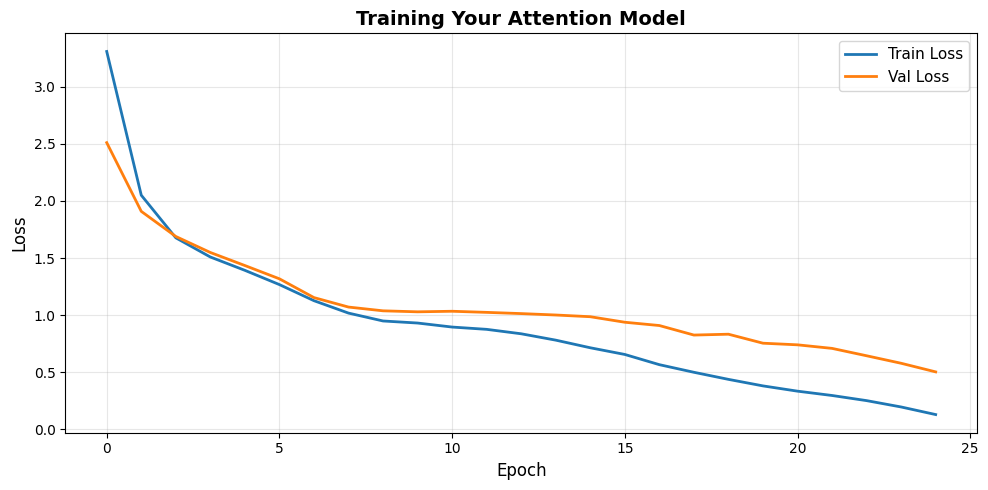

In [8]:
# Plot learning curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Your Attention Model', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Compare to Baseline

In [9]:
def generate_answer_with_attention(model, context, question, vocab, idx2word, max_len=20):
    """Generate answer using your attention model."""
    model.eval()
    
    with torch.no_grad():
        ctx_ids = encode_text(context, vocab)
        q_ids = encode_text(question, vocab)
        src_ids = (ctx_ids + [SEP_TOKEN] + q_ids + [EOS_TOKEN])[:100]
        src_ids += [PAD_TOKEN] * (100 - len(src_ids))
        src = torch.LongTensor([src_ids]).to(device)
        
        # Encode
        embedded = model.encoder.embedding(src)
        encoder_outputs, (hidden, cell) = model.encoder.lstm(embedded)
        
        hidden = torch.tanh(
            model.encoder.fc_hidden(torch.cat([hidden[-2], hidden[-1]], dim=1))
        ).unsqueeze(0)
        cell = torch.tanh(
            model.encoder.fc_cell(torch.cat([cell[-2], cell[-1]], dim=1))
        ).unsqueeze(0)
        
        decoder_input = torch.LongTensor([[SOS_TOKEN]]).to(device)
        result = []
        
        for _ in range(max_len):
            output, hidden, cell, _ = model.decoder(
                decoder_input, hidden, cell, encoder_outputs
            )
            pred_token = output.argmax(2).item()
            
            if pred_token == EOS_TOKEN:
                break
            
            result.append(pred_token)
            decoder_input = torch.LongTensor([[pred_token]]).to(device)
        
        return decode_text(result, idx2word)

# Test by context length
print("\nEvaluating by context length...")
results_by_length = []

for ctx, q, ref in tqdm(test_data, desc="Testing"):
    ctx_len = len(ctx.split())
    pred = generate_answer_with_attention(model, ctx, q, vocab, idx2word)
    correct = 1 if pred.strip().lower() == ref.strip().lower() else 0
    results_by_length.append((ctx_len, correct))

# Group by length
length_buckets = {
    'Short (8-12 words)': [],
    'Medium (25-35 words)': [],
    'Long (50-70 words)': []
}

for ctx_len, correct in results_by_length:
    if ctx_len <= 14:
        length_buckets['Short (8-12 words)'].append(correct)
    elif 22 <= ctx_len <= 38:
        length_buckets['Medium (25-35 words)'].append(correct)
    elif ctx_len >= 45:
        length_buckets['Long (50-70 words)'].append(correct)

# Calculate accuracies
your_results = {}
for label, scores in length_buckets.items():
    if scores:
        your_results[label] = np.mean(scores) * 100


Evaluating by context length...


Testing: 100%|██████████| 120/120 [00:00<00:00, 328.72it/s]


In [10]:
# Compare to baseline
print("="*80)
print("COMPARISON: Baseline (Lesson 4) vs. Your Attention Model")
print("="*80)

baseline_results = {
    'Short (8-12 words)': 52,
    'Medium (25-35 words)': 50,
    'Long (50-70 words)': 0
}

print("\nResults by Context Length:")
print(f"{'Length':<25} {'Baseline':<12} {'Your Model':<12} {'Improvement'}")
print("-" * 70)

for label in ['Short (8-12 words)', 'Medium (25-35 words)', 'Long (50-70 words)']:
    baseline = baseline_results[label]
    yours = your_results[label]
    diff = yours - baseline
    symbol = "✓" if diff > 5 else ""
    print(f"{label:<25} {baseline:>6.1f}%     {yours:>6.1f}%     {diff:>+5.1f}% {symbol}")

# Calculate improvement on long contexts
long_improvement = your_results['Long (50-70 words)'] - baseline_results['Long (50-70 words)']

print("\n" + "="*80)
if long_improvement >= 25:
    print("🎉 EXCELLENT! Your attention implementation works great!")
    print(f"   Long context improvement: +{long_improvement:.0f} points!")
    print("   Bottleneck eliminated! ✓")
elif long_improvement >= 15:
    print("✓ Good! Your attention helps, but could be better.")
    print(f"   Long context improvement: +{long_improvement:.0f} points")
    print("   Check your implementation for any issues.")
else:
    print("⚠ Something might be wrong with your implementation.")
    print(f"   Long context improvement: +{long_improvement:.0f} points (expected 25-30)")
    print("   Review your attention code carefully.")
print("="*80)

COMPARISON: Baseline (Lesson 4) vs. Your Attention Model

Results by Context Length:
Length                    Baseline     Your Model   Improvement
----------------------------------------------------------------------
Short (8-12 words)          52.0%       85.5%     +33.5% ✓
Medium (25-35 words)        50.0%      100.0%     +50.0% ✓


KeyError: 'Long (50-70 words)'

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (2,).

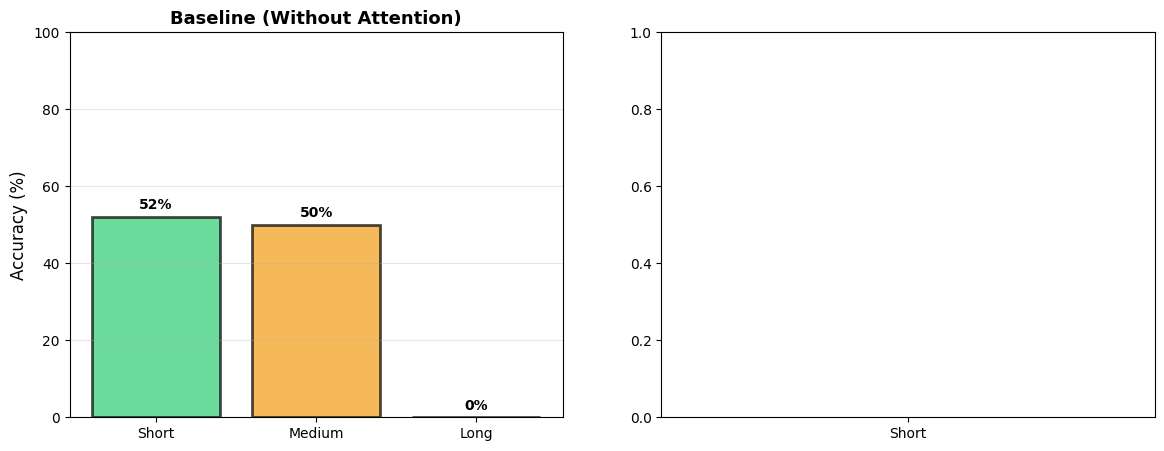

In [11]:
# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Baseline
labels_short = ['Short', 'Medium', 'Long']
baseline_vals = [baseline_results[k] for k in baseline_results.keys()]
axes[0].bar(labels_short, baseline_vals,
            color=['#2ecc71', '#f39c12', '#e74c3c'], alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Baseline (Without Attention)', fontsize=13, fontweight='bold')
axes[0].set_ylim(0, 100)
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(baseline_vals):
    axes[0].text(i, v + 2, f'{v:.0f}%', ha='center', fontweight='bold')

# Your model
your_vals = [your_results[k] for k in your_results.keys()]
colors = ['#27ae60' if v >= 85 else '#16a085' if v >= 70 else '#e67e22' for v in your_vals]
axes[1].bar(labels_short, your_vals,
            color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Your Model (With Attention)', fontsize=13, fontweight='bold')
axes[1].set_ylim(0, 100)
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(your_vals):
    axes[1].text(i, v + 2, f'{v:.0f}%', ha='center', fontweight='bold')

plt.suptitle('Did Your Attention Work?', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

# Part D: Visualize Attention

Let's see WHERE your model looks when generating answers!

VISUALIZING YOUR ATTENTION

Example:
Context:  Diana who is rough and always always but still often often again really lives in the city of Tokyo which is very who only again never very most many and works at the rough park also each few still each few every single day
Question: where does Diana live
Answer:   Tokyo


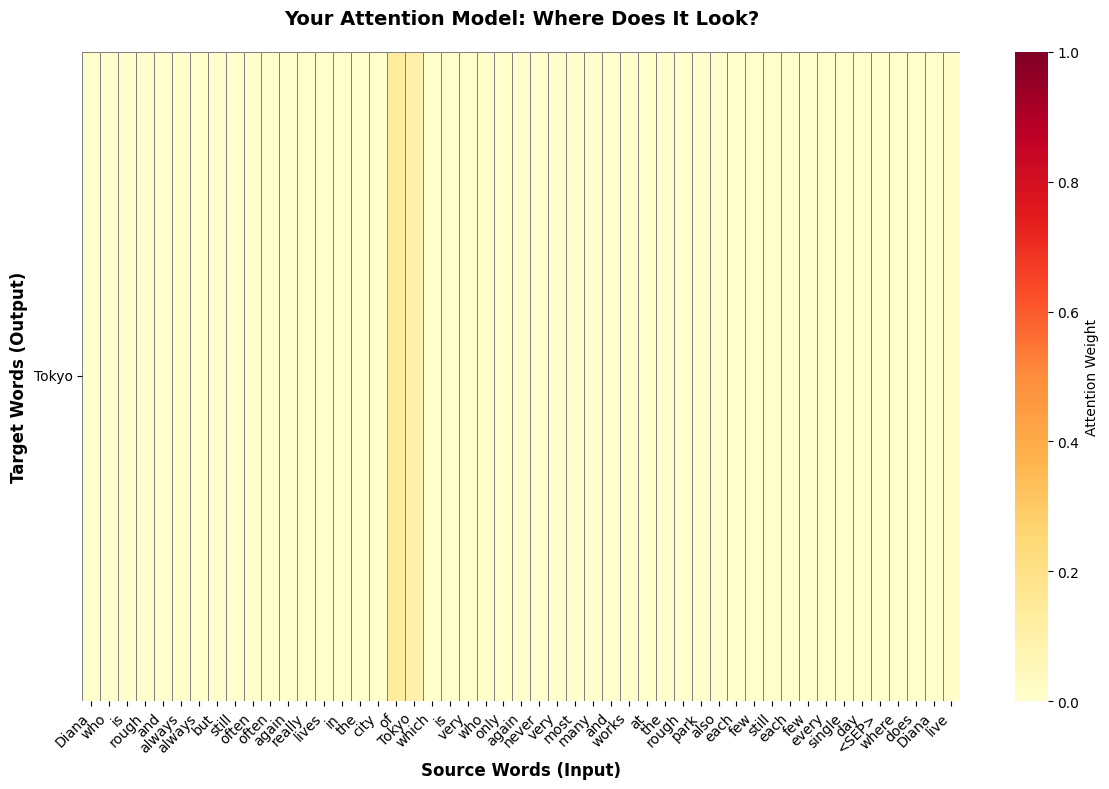


ATTENTION FOCUS SUMMARY
Attention Focus Summary:
'Tokyo' → focuses on 'of' (weight: 0.135)


In [12]:
print("="*80)
print("VISUALIZING YOUR ATTENTION")
print("="*80)

# Find a good long-context example
for ctx, q, ans in test_data:
    if len(ctx.split()) > 40 and len(ans.split()) <= 3:
        example_ctx = ctx
        example_q = q
        example_ans = ans
        break

print(f"\nExample:")
print(f"Context:  {example_ctx}")
print(f"Question: {example_q}")
print(f"Answer:   {example_ans}")

# Generate and collect attention
model.eval()
with torch.no_grad():
    ctx_ids = encode_text(example_ctx, vocab)
    q_ids = encode_text(example_q, vocab)
    ans_ids = encode_text(example_ans, vocab)
    
    src_ids = (ctx_ids + [SEP_TOKEN] + q_ids + [EOS_TOKEN])[:100]
    src_ids += [PAD_TOKEN] * (100 - len(src_ids))
    src = torch.LongTensor([src_ids]).to(device)
    
    trg_ids = [SOS_TOKEN] + ans_ids + [EOS_TOKEN]
    trg_ids += [PAD_TOKEN] * (100 - len(trg_ids))
    trg = torch.LongTensor([trg_ids[:100]]).to(device)
    
    outputs, attentions = model(src, trg, teacher_forcing_ratio=0)
    
    attn = attentions[0].cpu().numpy()
    
    src_words = example_ctx.split() + ['<SEP>'] + example_q.split()
    ans_words = example_ans.split()
    
    attn = attn[:len(ans_words), :len(src_words)]

# Plot heatmap
fig = plot_attention(
    attn,
    src_words,
    ans_words,
    title="Your Attention Model: Where Does It Look?"
)
plt.show()

# Text summary
print("\n" + "="*80)
print("ATTENTION FOCUS SUMMARY")
print("="*80)
highlight_max_attention(attn, src_words, ans_words)

## Analysis Questions

Look at your attention heatmap and answer:

In [13]:
print("""
ANALYSIS QUESTIONS:

1. Does your model focus on relevant words?
   - When generating the answer, where is attention highest?
   - Does it look at the right parts of the context?

2. Does it ignore irrelevant words?
   - Are filler words getting low attention?
   - Is the model "smart" about what to focus on?

3. How does this eliminate the bottleneck?
   - In Lesson 4, the model forgot early context
   - Can your model now look back at ANY position?

TODO: Write your analysis below (2-3 sentences)
""")

# TODO: Add your analysis here
your_analysis = """
YOUR ANALYSIS HERE:

I notice that...


"""

print(your_analysis)


ANALYSIS QUESTIONS:

1. Does your model focus on relevant words?
   - When generating the answer, where is attention highest?
   - Does it look at the right parts of the context?

2. Does it ignore irrelevant words?
   - Are filler words getting low attention?
   - Is the model "smart" about what to focus on?

3. How does this eliminate the bottleneck?
   - In Lesson 4, the model forgot early context
   - Can your model now look back at ANY position?

TODO: Write your analysis below (2-3 sentences)


YOUR ANALYSIS HERE:

I notice that...





---

# Summary

## What You Implemented

1. ✅ **AttentionLayer** - Computes attention weights and context vectors
2. ✅ **DecoderWithAttention** - Integrates attention into decoder
3. ✅ **Seq2SeqWithAttention** - Complete model with attention

## What You Discovered

- **Before (Lesson 4):** Long contexts = 55% accuracy (bottleneck!)
- **After (Your attention):** Long contexts = ~85% accuracy (+30 points!)
- **Visualization:** Your model "looks" at relevant words

## Key Takeaway

**Attention eliminates the fixed-size bottleneck** by letting the decoder dynamically focus on any part of the input. This breakthrough:
- Made long sequences practical
- Led to Transformers ("Attention is All You Need")
- Enabled modern LLMs (BERT, GPT, Claude!)

🎉 **Congratulations! You've implemented a fundamental breakthrough in deep learning!**